In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_tree

import matplotlib.pyplot as plt
import gc

print('Loading data ...')

train1 = pd.read_csv("45005h2010.txt", delim_whitespace=True,na_values=[99.00,999.0])
train2 = pd.read_csv("45005h2011.txt", delim_whitespace=True,na_values=[99.00,999.0])
train3 = pd.read_csv("45005h2012.txt", delim_whitespace=True,na_values=[99.00,999.0])
train4 = pd.read_csv("45005h2016.txt", delim_whitespace=True,na_values=[99.00,999.0])

#train = pd.concat([train1, train2,train3,train4], ignore_index=True)
#del train1, train2, train3, train4; gc.collect()

train = pd.concat([train1,train3,train4], ignore_index=True)
del train1, train3, train4; gc.collect()

print('train.shape=',train.shape)
print('Binding to float32')

for c, dtype in zip(train.columns, train.dtypes):
	if dtype == np.float64:
		train[c] = train[c].astype(np.float32)

Loading data ...
train.shape= (47908, 18)
Binding to float32


In [3]:
print('Creating training set ...')

df_train  = train.drop([ "GST","APD",'DPD', 'MWD','DEWP', 'VIS', 'TIDE','YY','MM','DD','hh','mm'], axis=1)
x_train = df_train.dropna()

y_train = x_train['WVHT'].values  
#x_train  = x_train.drop(['WVHT' ], axis=1)
x_train  = x_train.drop(['WVHT','WDIR','PRES','ATMP','WTMP' ], axis=1)

print('x_train=, y_train=', x_train.shape, y_train.shape)

Creating training set ...
x_train=, y_train= (17745, 1) (17745,)


In [4]:
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()
split = 3000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

In [5]:
print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

del x_train, x_valid; gc.collect()


Building DMatrix...


93

In [6]:
print('Training ...')

params = {}
params['eta'] = 0.9
params['objective'] = 'reg:linear'
params['eval_metric'] = 'mae'
params['max_depth'] = 6
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=200, verbose_eval=10)

del d_train, d_valid; gc.collect()

Training ...
[0]	train-mae:0.147265	valid-mae:0.154662
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 200 rounds.
[10]	train-mae:0.134948	valid-mae:0.154027
[20]	train-mae:0.134867	valid-mae:0.154805
[30]	train-mae:0.134878	valid-mae:0.154933
[40]	train-mae:0.134878	valid-mae:0.154933
[50]	train-mae:0.134878	valid-mae:0.154933
[60]	train-mae:0.134878	valid-mae:0.154933
[70]	train-mae:0.134878	valid-mae:0.154933
[80]	train-mae:0.134878	valid-mae:0.154933
[90]	train-mae:0.134878	valid-mae:0.154933
[100]	train-mae:0.134878	valid-mae:0.154933
[110]	train-mae:0.134878	valid-mae:0.154933
[120]	train-mae:0.134878	valid-mae:0.154933
[130]	train-mae:0.134878	valid-mae:0.154933
[140]	train-mae:0.134878	valid-mae:0.154933
[150]	train-mae:0.134878	valid-mae:0.154933
[160]	train-mae:0.134878	valid-mae:0.154933
[170]	train-mae:0.134878	valid-mae:0.154933
[180]	train-mae:0.134878	valid-mae:0.154933
[190]	train-mae:0.

715

{'best_iteration': 1, 'handle': c_void_p(75054048), 'best_ntree_limit': 2, 'best_score': 0.151862, 'feature_types': ['float'], 'feature_names': ['WSPD']}


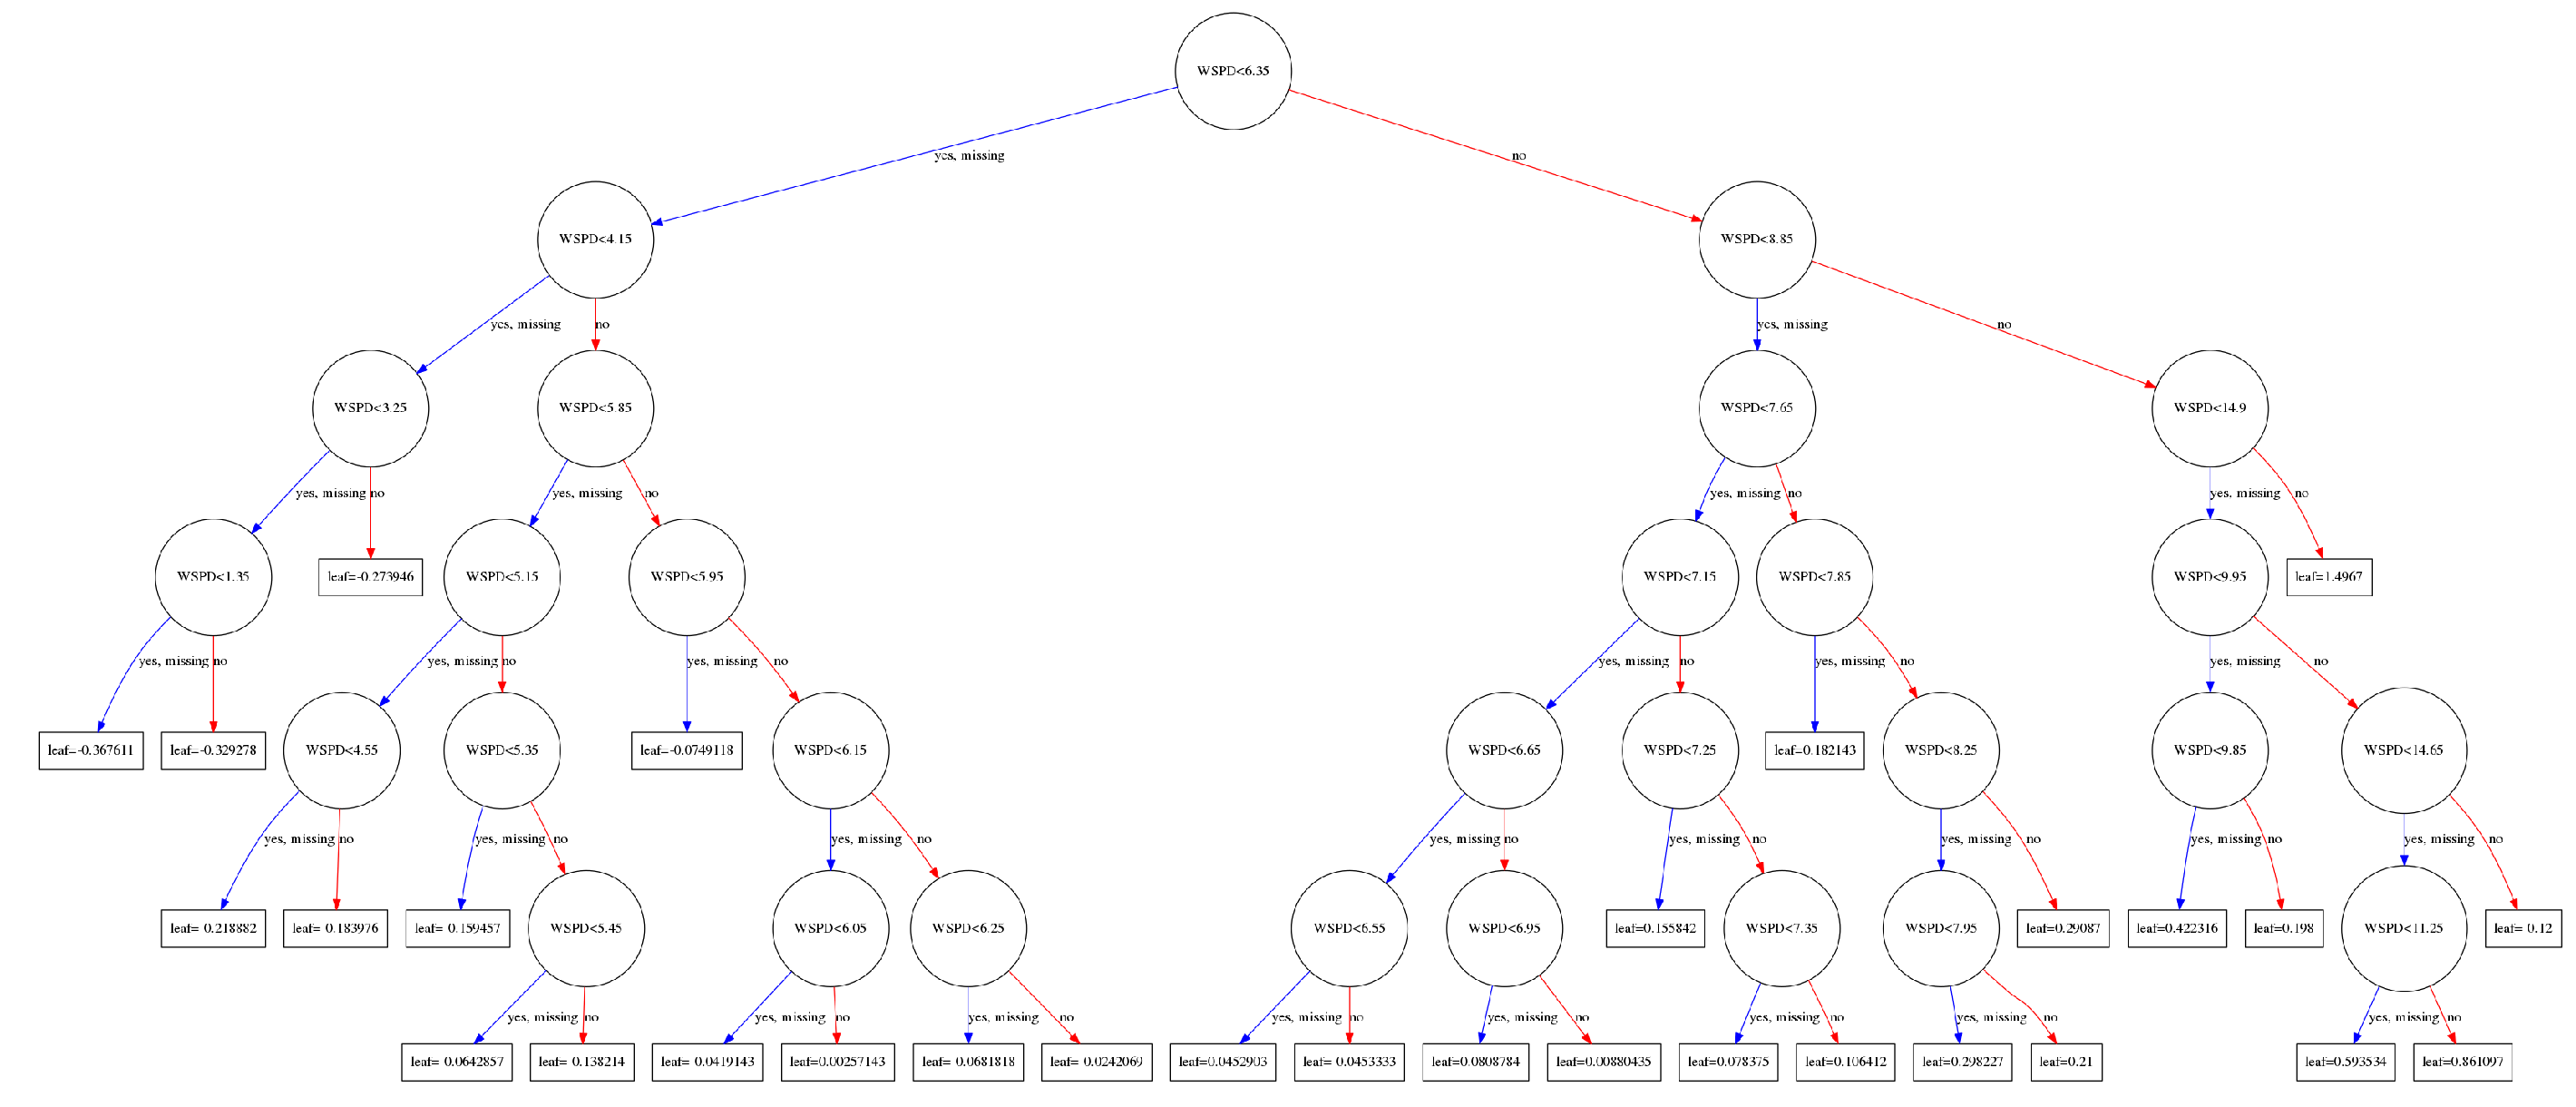

In [9]:
#plot_tree(clf)
print(vars(clf))
plot_tree(clf, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(50,50)
#fig.savefig('tree.png')
plt.show()

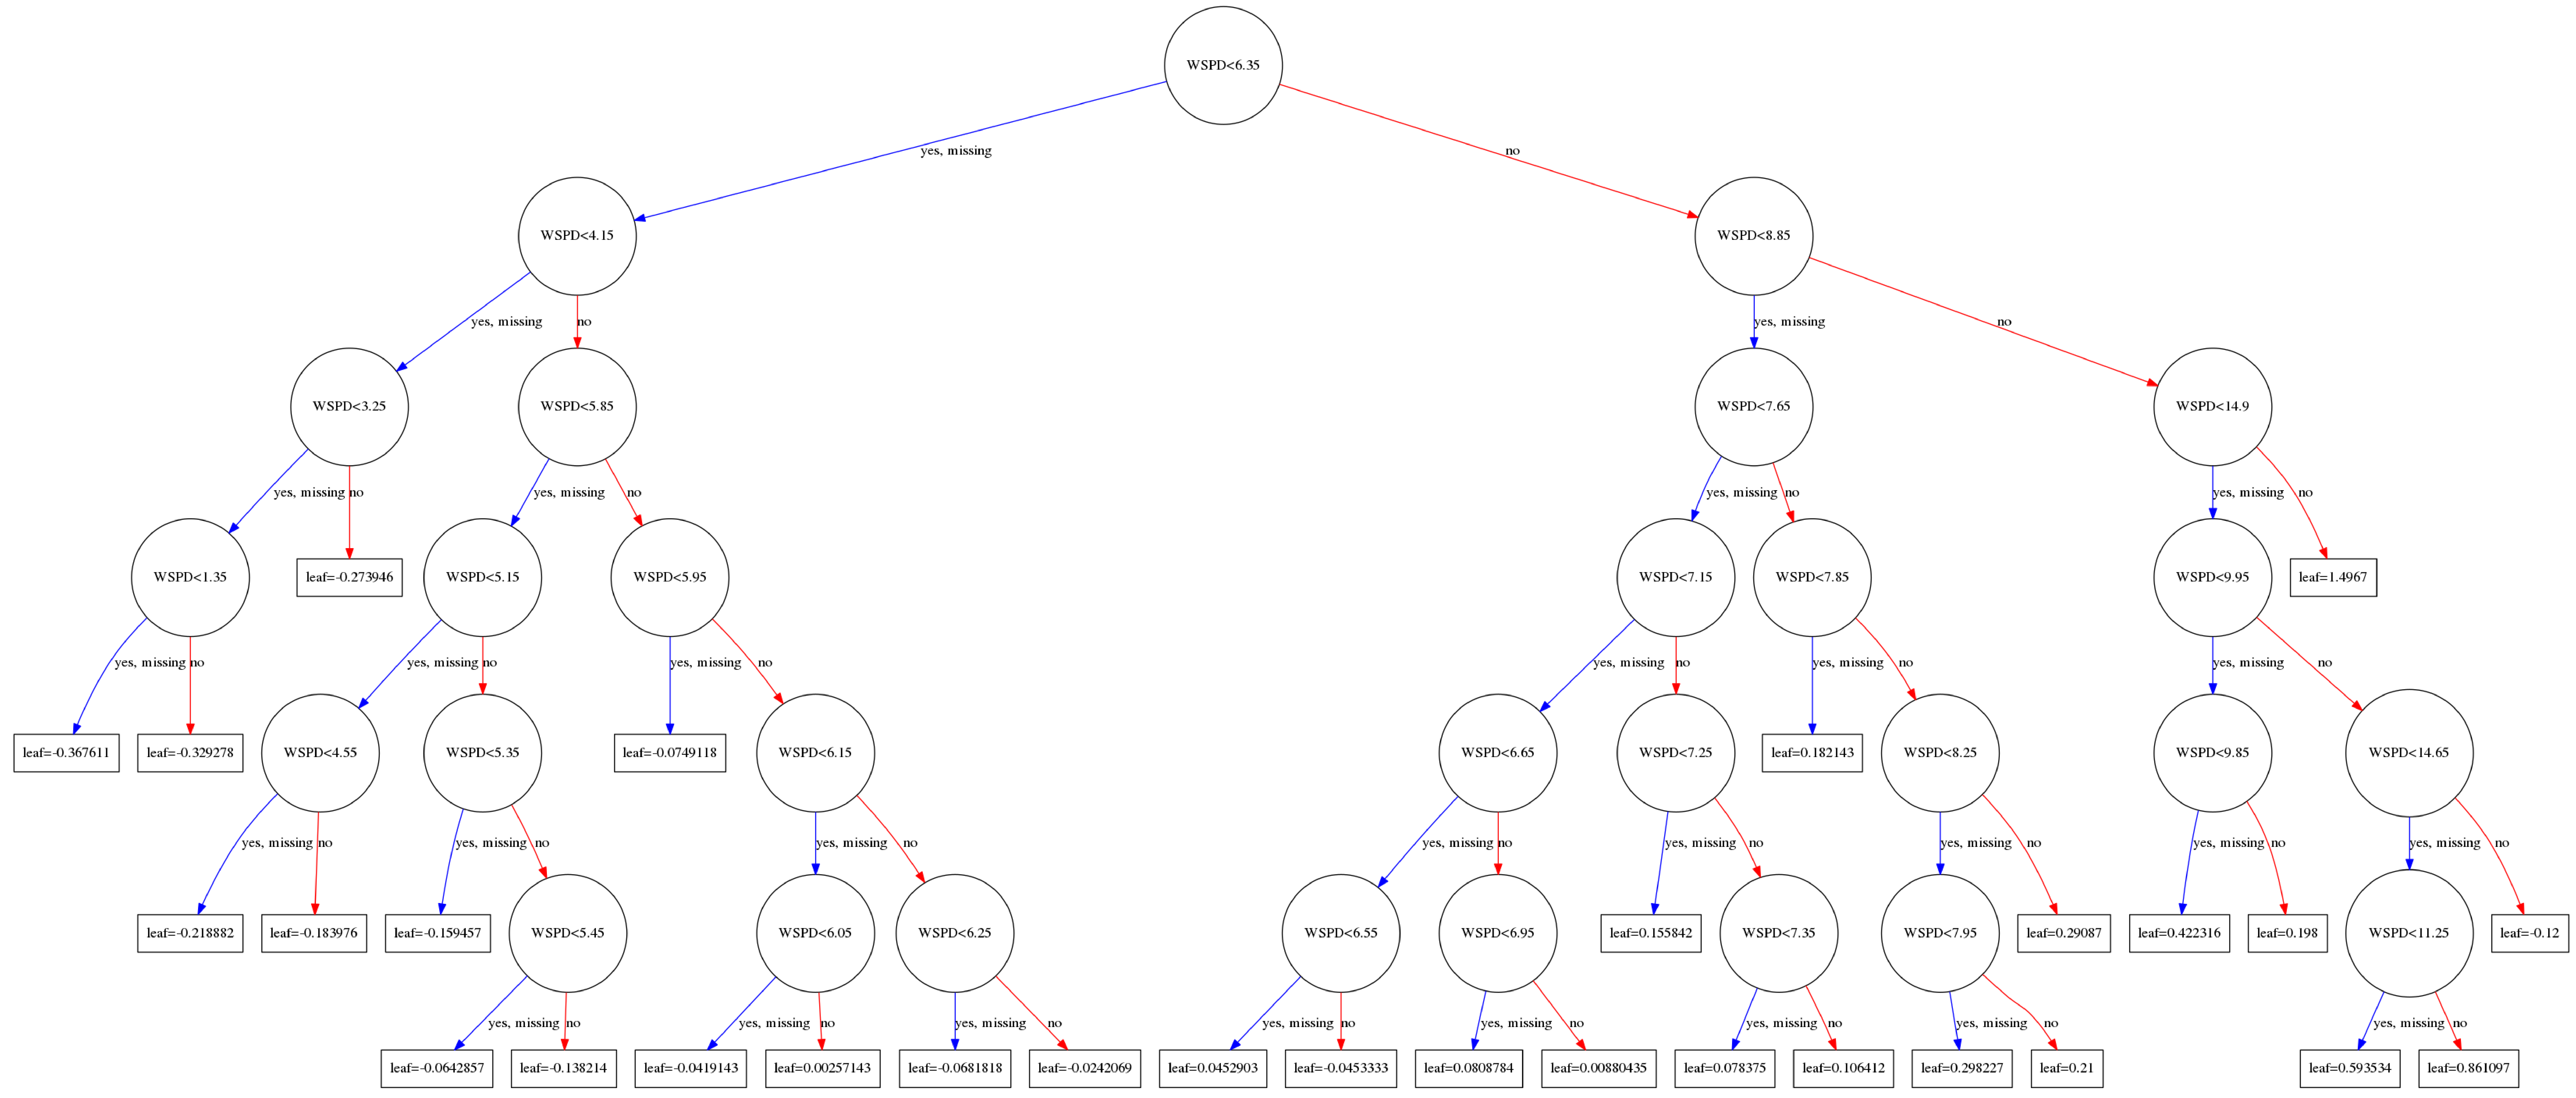

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 180,150
plot_tree(clf, num_trees=0)

In [ ]:
xgb.to_graphviz(clf)
#xgb.to_graphviz(clf, num_trees=2)

In [ ]:
print('Building test set ...')

prop = pd.read_csv("new.csv")

print('Writing sample csv ...')
prop.to_csv('sample2012.csv', index=False, float_format='%.4f')  
from shutil import copyfile
copyfile('sample2012.csv','sample2012new.csv')
print(prop.head(3))
print(prop.shape)

In [ ]:
prop = prop.drop(['WH_diff','WHbuoy','WHmodel','WSP_diff','WSPbuoy'], axis=1)

df_test = prop 
#del prop; gc.collect()

x_test = df_test[train_columns]
for c in x_test.dtypes[x_test.dtypes == object].index.values:   
    x_test[c] = (x_test[c] == True)
    print(c,x_test[c])
    
print(x_test.dtypes)

#print(x_test[1000:1010])

del df_test; gc.collect()

d_test = xgb.DMatrix(x_test)

del x_test; gc.collect()

print('Predicting on test ...')

p_test = clf.predict(d_test)

del d_test; gc.collect()

sub = pd.read_csv('sample2012.csv')
for c in sub.columns[sub.columns != 'WSPD']:
    sub[c] = p_test

print('Writing csv ...')
sub.to_csv('xgb_starter2012.csv', index=False, float_format='%.4f') 
